In [1]:
"""Import the required modules"""
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import timeit

Analyzing welding data by welding types

In [2]:
df2 = pd.read_csv('welding_data_by_welding_types.csv')
df2 = pd.get_dummies(df2).drop('welding_type_GMAW', axis=1)
df2 = df2[['current', 'voltage', 'welding_speed', 'plate_thickness',	'welding_type_SAW',	'welding_type_SMAW',	              'welding_type_GTAW', 'heat_input', 'flexural_strength', 'hardness_value', 'residual_stress',
           'tensile_strength']]
df2.head()

,current,voltage,welding_speed,plate_thickness,welding_type_SAW,welding_type_SMAW,welding_type_GTAW,heat_input,flexural_strength,hardness_value,residual_stress,tensile_strength
0,160,32,120,6,0,0,1,1536,236.2,102.5,152.0,432.6
1,130,32,90,8,0,1,0,2218,270.2,96.4,270.2,332.8
2,100,28,120,8,0,0,1,840,360.8,86.4,90.5,382.4
3,160,28,90,10,0,0,1,1792,230.0,105.0,165.4,422.8
4,100,28,120,8,1,0,0,1400,276.5,128.4,186.6,385.5


Exploratory data analysis

In [3]:
# pos = 1
# for i in range(4):
#   print(f'\t{df2.columns[i].capitalize()} vs Response values')
#   plt.figure()
#   for j in range(8, 11):
#     plt.subplot(1, 3, pos)
#     plt.scatter(df2.iloc[:, i], df2.iloc[:, j])
#     plt.ylabel(df2.columns[j])
#     plt.xlabel(df2.columns[i])
#     pos += 1
#   plt.tight_layout()
#   plt.show()
#   print('\n')
#   pos = 1

Generate the necessary variables for modeling

In [4]:
X1 = df2.iloc[:, :7]
X = X1.to_numpy()
y1 = df2.iloc[:, -5:]
y = y1.to_numpy()

In [5]:
def relu(x):
   return np.maximum(x, 0, x)

In [6]:
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

In [7]:
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

In [8]:
def MAD(y, y_pred):
    '''Calculates the Mean Absolute Deviation of two arrays of numbers
    Input: y(array), y_pred(array)
    Output: float
    '''
    import numpy as np

    return np.average(np.abs(y - y_pred))

In [9]:
def MAPE(y, y_pred):
    '''
    Calculates the relationship between the average prediction error
    and the average expected target error for several consecutive periods.

    Input: y(array), y_pred(array)
    Output: float
    '''
    import numpy as np

    # Calculate prediction error
    error = y - y_pred

    return np.average((np.abs(error)/y) * 100)

In [10]:
def TS(y, y_pred):
    '''
    This index is used to track the accuracy of the model

    Input: y(array), y_pred(array)
    Output: float
    '''
    import numpy as np

    def MAD(y, y_pred):
        '''Calculates the Mean Absolute Deviation of two arrays of numbers
        Input: y(array), y_pred(array)
        Output: float
        '''
        return np.average(np.abs(y - y_pred))

    return np.sum(y - y_pred) / MAD(y, y_pred)

In [11]:
def split_name(name, char='_'):
    index = name.find(char)
    return name[:index].capitalize() + ' ' + name[index+1:].capitalize()


In [12]:
# Split data in readiness for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

# Convert test data to dataframe and print it.
y_test_df = pd.DataFrame(y_test, columns=['heat_input', 'flexural_strength',	'hardness_value',	'residual_stress',	'tensile_strength'])

Predicting individual response separately to optimize prediction


heat_input: 5 Nodes


,Expected,Predicted
0,1120.0,1120.410083
1,1280.0,1268.305762
2,960.0,957.286980
3,1792.0,1868.950054
4,1024.0,1014.571319
5,2048.0,2032.256087
6,936.0,919.723124
7,768.0,756.816561


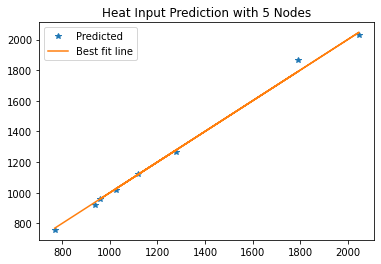


flexural_strength: 5 Nodes


,Expected,Predicted
0,218.4,209.853209
1,238.4,243.630954
2,336.8,290.096500
3,230.0,319.911719
4,196.0,204.931756
5,260.0,277.737262
6,345.0,290.998668
7,394.4,355.582368


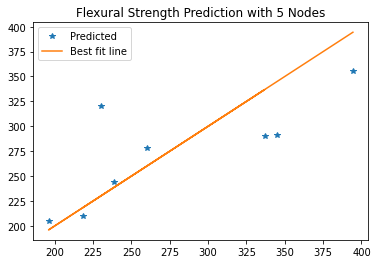


hardness_value: 5 Nodes


,Expected,Predicted
0,132.5,145.537743
1,116.2,110.315133
2,90.6,85.394589
3,105.0,97.888250
4,142.2,138.103348
5,110.0,115.036980
6,80.5,97.426196
7,65.0,75.878569


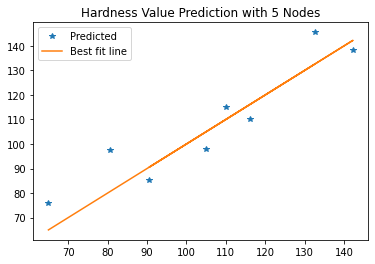


residual_stress: 5 Nodes


,Expected,Predicted
0,188.6,176.188809
1,216.8,218.543820
2,125.8,116.209500
3,165.4,191.023691
4,164.0,172.937559
5,264.6,263.615817
6,108.6,107.161203
7,82.0,89.213594


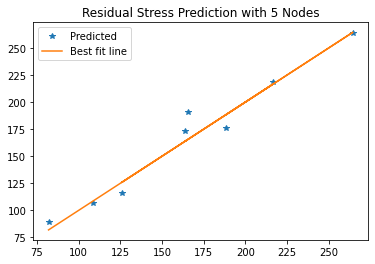


tensile_strength: 5 Nodes


,Expected,Predicted
0,312.8,312.695495
1,442.6,432.099269
2,396.5,468.518553
3,422.8,400.006513
4,280.2,288.747144
5,304.2,329.511036
6,394.6,417.243441
7,378.5,362.470250


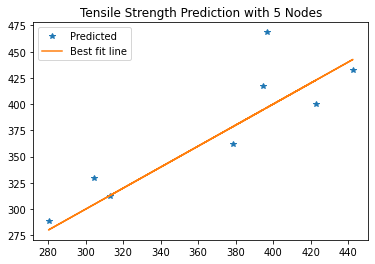


heat_input: 10 Nodes


,Expected,Predicted
0,1120.0,1127.416433
1,1280.0,1279.158265
2,960.0,899.435059
3,1792.0,1845.835539
4,1024.0,1012.615952
5,2048.0,2032.626447
6,936.0,891.426648
7,768.0,764.445285


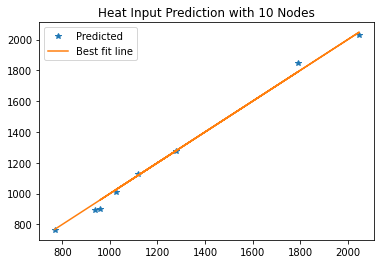


flexural_strength: 10 Nodes


,Expected,Predicted
0,218.4,217.879546
1,238.4,240.510318
2,336.8,293.845153
3,230.0,312.512122
4,196.0,197.411387
5,260.0,257.625776
6,345.0,292.161027
7,394.4,356.328931


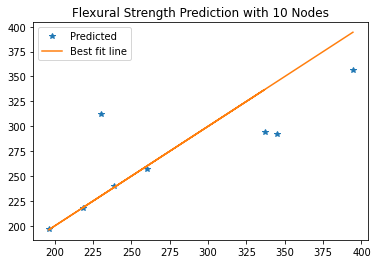


hardness_value: 10 Nodes


,Expected,Predicted
0,132.5,137.420222
1,116.2,113.482542
2,90.6,88.171645
3,105.0,98.586276
4,142.2,136.266131
5,110.0,107.347797
6,80.5,94.161205
7,65.0,80.731335


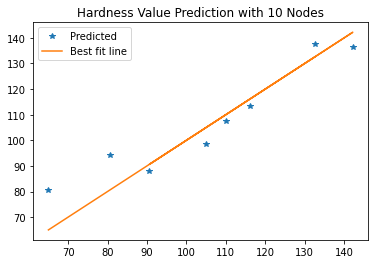


residual_stress: 10 Nodes


,Expected,Predicted
0,188.6,184.491920
1,216.8,219.482837
2,125.8,119.418244
3,165.4,194.301215
4,164.0,161.390448
5,264.6,266.046413
6,108.6,108.400379
7,82.0,79.693052


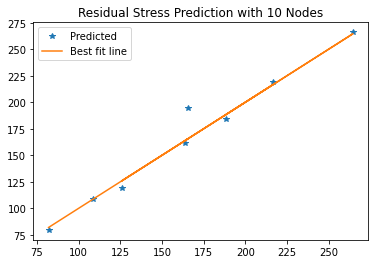


tensile_strength: 10 Nodes


,Expected,Predicted
0,312.8,322.533790
1,442.6,444.031359
2,396.5,481.026558
3,422.8,363.367267
4,280.2,277.402746
5,304.2,333.244296
6,394.6,438.173140
7,378.5,344.791137


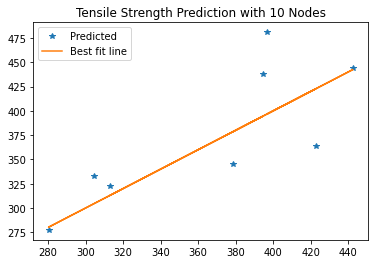


heat_input: 15 Nodes


,Expected,Predicted
0,1120.0,1120.116176
1,1280.0,1271.911792
2,960.0,927.126258
3,1792.0,1857.968745
4,1024.0,1021.953927
5,2048.0,2041.817302
6,936.0,917.248195
7,768.0,759.901875


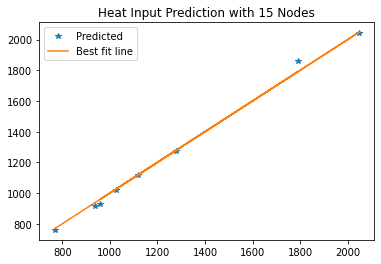


flexural_strength: 15 Nodes


,Expected,Predicted
0,218.4,212.580357
1,238.4,235.619984
2,336.8,308.440786
3,230.0,307.448563
4,196.0,207.236713
5,260.0,270.813592
6,345.0,294.454548
7,394.4,356.075886


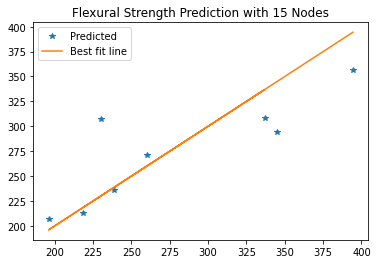


hardness_value: 15 Nodes


,Expected,Predicted
0,132.5,133.989851
1,116.2,115.922574
2,90.6,75.162436
3,105.0,97.842620
4,142.2,138.546765
5,110.0,109.428358
6,80.5,82.755923
7,65.0,82.381470


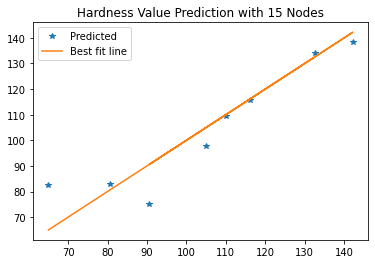


residual_stress: 15 Nodes


,Expected,Predicted
0,188.6,180.218395
1,216.8,220.053716
2,125.8,118.528892
3,165.4,194.007666
4,164.0,176.028210
5,264.6,265.176579
6,108.6,108.170756
7,82.0,98.048076


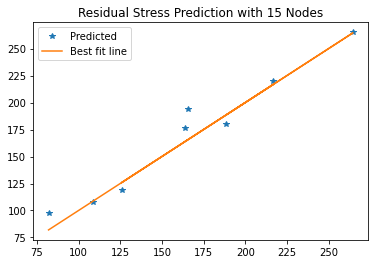


tensile_strength: 15 Nodes


,Expected,Predicted
0,312.8,321.506884
1,442.6,437.027347
2,396.5,461.474608
3,422.8,376.535721
4,280.2,279.067647
5,304.2,333.198772
6,394.6,427.811922
7,378.5,360.287206


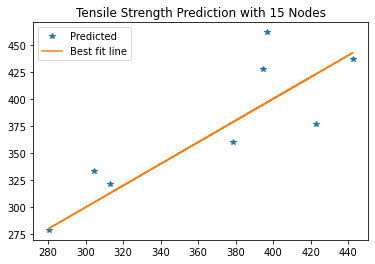


heat_input: 20 Nodes


,Expected,Predicted
0,1120.0,1123.175455
1,1280.0,1270.653511
2,960.0,880.014199
3,1792.0,1853.210608
4,1024.0,1017.836507
5,2048.0,2045.696935
6,936.0,901.810583
7,768.0,761.136913


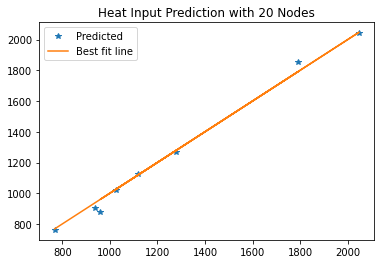


flexural_strength: 20 Nodes


,Expected,Predicted
0,218.4,211.016863
1,238.4,224.412903
2,336.8,298.335546
3,230.0,278.755588
4,196.0,203.222443
5,260.0,257.581107
6,345.0,296.439212
7,394.4,353.689006


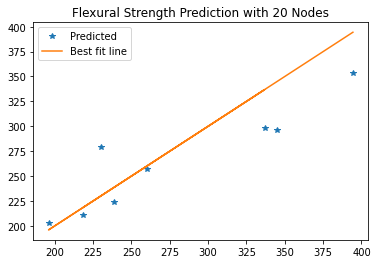


hardness_value: 20 Nodes


,Expected,Predicted
0,132.5,137.390901
1,116.2,121.176588
2,90.6,90.693411
3,105.0,100.497657
4,142.2,138.262011
5,110.0,110.667278
6,80.5,92.721208
7,65.0,79.877735


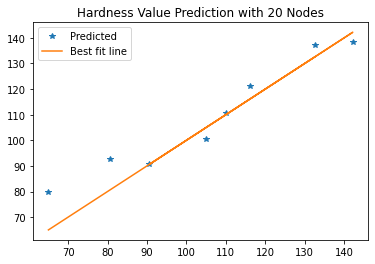


residual_stress: 20 Nodes


,Expected,Predicted
0,188.6,180.811995
1,216.8,218.741588
2,125.8,115.271885
3,165.4,192.859559
4,164.0,171.842001
5,264.6,266.150600
6,108.6,105.937136
7,82.0,89.886262


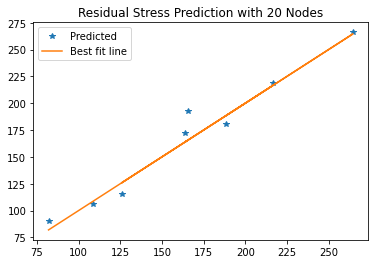


tensile_strength: 20 Nodes


,Expected,Predicted
0,312.8,322.401329
1,442.6,437.969390
2,396.5,472.799440
3,422.8,380.197565
4,280.2,277.776445
5,304.2,328.196380
6,394.6,428.432477
7,378.5,356.577137


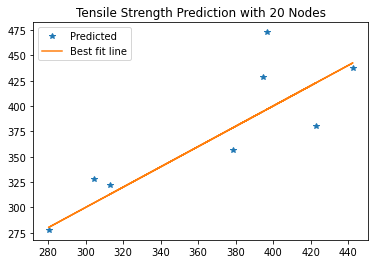


heat_input: 25 Nodes


,Expected,Predicted
0,1120.0,1123.588766
1,1280.0,1295.749973
2,960.0,863.824997
3,1792.0,1871.451630
4,1024.0,1017.573478
5,2048.0,2048.482978
6,936.0,894.754457
7,768.0,762.783725


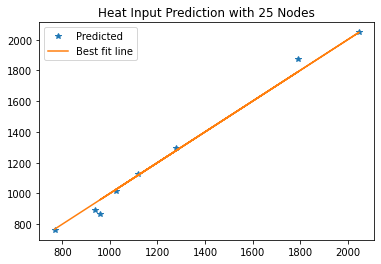


flexural_strength: 25 Nodes


,Expected,Predicted
0,218.4,214.755980
1,238.4,232.766800
2,336.8,292.950837
3,230.0,299.561484
4,196.0,198.897935
5,260.0,253.114030
6,345.0,292.280129
7,394.4,353.962521


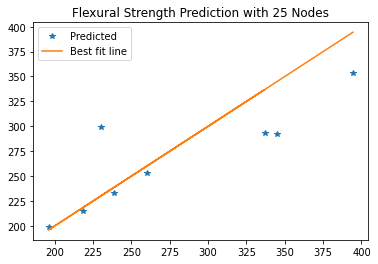


hardness_value: 25 Nodes


,Expected,Predicted
0,132.5,139.453878
1,116.2,119.800720
2,90.6,92.241389
3,105.0,101.274233
4,142.2,134.384115
5,110.0,106.927961
6,80.5,97.199177
7,65.0,82.361502


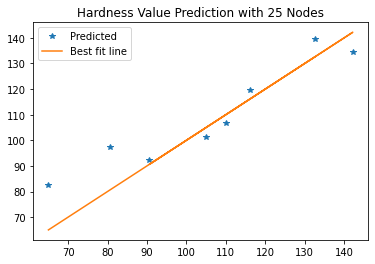


residual_stress: 25 Nodes


,Expected,Predicted
0,188.6,180.461107
1,216.8,220.793682
2,125.8,115.264214
3,165.4,191.015683
4,164.0,176.715072
5,264.6,266.229801
6,108.6,104.858474
7,82.0,89.399472


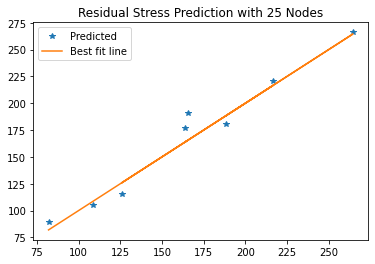


tensile_strength: 25 Nodes


,Expected,Predicted
0,312.8,321.467706
1,442.6,431.228297
2,396.5,481.490314
3,422.8,364.664679
4,280.2,276.839225
5,304.2,329.782208
6,394.6,424.543651
7,378.5,353.391913


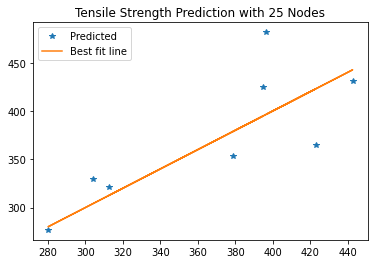


heat_input: 30 Nodes


,Expected,Predicted
0,1120.0,1123.926842
1,1280.0,1284.719134
2,960.0,899.912068
3,1792.0,1860.848817
4,1024.0,1021.318243
5,2048.0,2043.558491
6,936.0,911.000410
7,768.0,759.030333


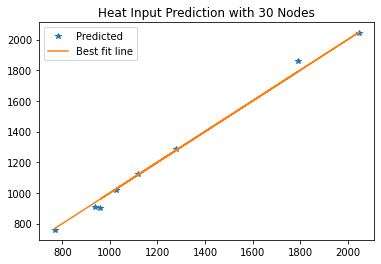


flexural_strength: 30 Nodes


,Expected,Predicted
0,218.4,215.221399
1,238.4,235.103269
2,336.8,295.611458
3,230.0,309.951449
4,196.0,202.568417
5,260.0,272.303840
6,345.0,298.121375
7,394.4,358.811703


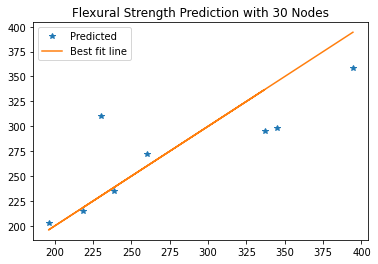


hardness_value: 30 Nodes


,Expected,Predicted
0,132.5,137.217036
1,116.2,114.461783
2,90.6,82.502519
3,105.0,98.876523
4,142.2,141.463944
5,110.0,105.989551
6,80.5,96.891926
7,65.0,80.397928


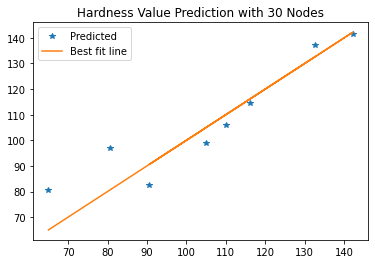


residual_stress: 30 Nodes


,Expected,Predicted
0,188.6,179.345341
1,216.8,221.730621
2,125.8,118.841223
3,165.4,189.800630
4,164.0,174.904091
5,264.6,266.644865
6,108.6,108.060558
7,82.0,96.462460


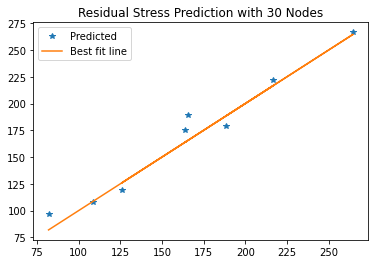


tensile_strength: 30 Nodes


,Expected,Predicted
0,312.8,322.020240
1,442.6,433.000831
2,396.5,459.939917
3,422.8,372.231920
4,280.2,276.379752
5,304.2,335.377253
6,394.6,423.608929
7,378.5,359.526969


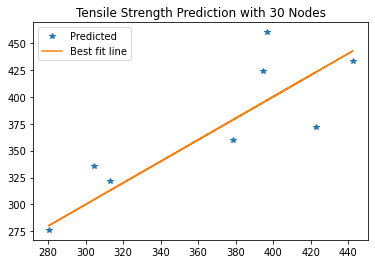

,Variable,Nodes,R2,MSE,RMSE,MAD,MAPE,TS,Time
0,heat_input,5,0.995487,849.046438,29.138401,18.050038,1.301449,-0.571742,0.002116
1,flexural_strength,5,0.206446,1897.885476,43.564727,33.735118,11.992531,0.778345,0.004491
2,hardness_value,5,0.823278,91.160100,9.547780,8.522271,9.080674,-2.766963,0.000991
3,residual_stress,5,0.958208,130.073055,11.404957,8.492917,5.805526,-2.248226,0.000473
4,tensile_strength,5,0.738801,912.483969,30.207350,22.243581,5.913108,-3.555709,0.003427
5,heat_input,10,0.994104,1123.431456,33.517629,24.693039,2.141044,3.038928,0.001828
6,flexural_strength,10,0.331915,1613.385716,40.166973,27.849174,9.544246,1.821445,0.000062
7,hardness_value,10,0.821219,69.371791,8.328973,6.807296,7.824635,-2.081172,0.001426
8,residual_stress,10,0.966094,114.293090,10.690795,6.079553,3.887141,-2.866084,0.000190
9,tensile_strength,10,0.581912,1832.510731,42.807835,33.030999,8.663084,-2.190981,0.000562


In [13]:
metrics = []
for hidden_size in range(1000, 6500, 1000):
    # print(f'\nELM Analysis for {hidden_size} Node(s)')
    for i in range(y.shape[1]):
        metric = [y1.columns[i], int(hidden_size/200)]
        cols = y[:, i]
        X_train, X_test, y_train, y_test = train_test_split(X, cols,random_state=1, test_size=0.2)

        tic = timeit.timeit() #Start timer
        input_size = X_train.shape[1]
        input_weights = np.random.normal(size=[input_size,hidden_size])
        biases = np.random.normal(size=[hidden_size])
        output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)
        prediction = predict(X_test)
        toc = timeit.timeit() #Stop timer

        # Display data
        print(f'\n{y1.columns[i]}: {int(hidden_size/200)} Nodes')
        a = []
        for j in range(len(y_test)):
            a.append([y_test[j], prediction[j]])

        a_df = pd.DataFrame(a, columns=['Expected', 'Predicted'])

        # Display output
        display(a_df)
        plt.plot(y_test, prediction, '*', label='Predicted')
        plt.plot(y_test, y_test, label='Best fit line')
        plt.title(f'{split_name(y1.columns[i])} Prediction with {int(hidden_size/200)} Nodes')
        plt.legend()
        plt.show()
        
        

        # Calculate the necessary metrics
        r2 = r2_score(prediction, y_test)
        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)
        mad = MAD(y_test, prediction)
        mape = MAPE(y_test, prediction)
        ts = TS(y_test, prediction)
        time = abs(toc - tic)

        metric.extend([r2, mse, rmse, mad, mape, ts, time])   # Update metric
        metrics.append(metric)  # Undate metrics


metrics_df = pd.DataFrame(metrics, columns=['Variable', 'Nodes', 'R2', 'MSE', 'RMSE', 'MAD', 'MAPE', 'TS', 'Time'])

display(metrics_df)